## Data Preparation and Exploration

In this notebook we will download the data for the example project, visualize it to understand the tasks we will solve and then convert it to suitable data formats for the different tasks.
We are using data from the paper [Microscopy-based assay for semi-quantitative detection of SARS-CoV-2 specific antibodies in human sera](https://onlinelibrary.wiley.com/doi/full/10.1002/bies.202000257) for segmentation and classification tasks in microscopy imaging.

This data was used in a serological assay for SARS-CoV-2 and we will use it for nucleus and cell segmentation as well as classifying cells into infect / non-infected.

In [1]:
!pip install wget
!pip install NumpyEncoder

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9655 sha256=b5790f7f7e0662f9af86eb7f2e97537c4143fd14055a18e7f4163fab1c8ba0d4
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


In [2]:
import os
import sys
import wget
from glob import glob
from shutil import move
import imageio
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.patches import Patch
from skimage import measure
from scipy.ndimage import zoom
import math
import requests
import json
import random
import numpy as np
import numpy.ma as ma


util_url = "https://owncloud.gwdg.de/index.php/s/XXKF3QE2s8tqS1H/download"
#util_url = "https://github.com/computational-cell-analytics/dl-for-micro/raw/main/utils.py"
src = "./"
dst_dir = "/kaggle/working/"
if not os.path.exists(os.path.join(src,"utils.py")):
    wget.download(util_url)
    move(os.path.join(src,"utils.py"), os.path.join(dst_dir, "utils.py"))
os.listdir("/kaggle/working")
import utils

# 1. Download and Prepare

The next step is to download the data from zenodo and unzip it. The utils.py provides a function that also converts the data into .tif file format and divides the files into three directories: 
- **train**: used for training a neural network
- val: used for validation
- test: used for testing a neural network 
  
Each of these directories contain folders with the .tif images and a labels.json.  

In [3]:
# download and extract data, then convert data into .tif
utils.prepare_data()

Download https://zenodo.org/record/5092850/files/covid-if-groundtruth.zip?download=1 to data/data.zip: 100%|██████████| 491M/491M [00:18<00:00, 28.0MB/s] 
100%|██████████| 49/49 [00:22<00:00,  2.21it/s]

We have 35 training images in data/train
We have 5 validation images in data/val
We have 9 test images in data/test


In [4]:
# get data directories and show content of one image folder 
data_dir = "data"
data_dirs = {
    "train": os.path.join(data_dir, "train"),
    "val": os.path.join(data_dir, "val"),
    "test": os.path.join(data_dir, "test")
}

print(os.listdir(os.path.join(data_dirs["train"], "gt_image_000")))

['gt_image_000_serum_image.tif', 'gt_image_000_nucleus_labels.tif', 'gt_image_000_infected_labels.tif', 'gt_image_000_cell_labels.tif', 'gt_image_000_nucleus_image.tif', 'labels.json', 'gt_image_000_marker_image.tif']


### Location
In the following code we find the paths to the files and folder. We also get the path to the `labels.json` file that contains the `cell_ids`, `infected_label` and the corresponding `bbox` (bounding boxes).

In [5]:
def get_file_paths(root_dir, of_type):
    tifs = []

    for dirpath, dirnames, filenames in os.walk(root_dir):
        for filename in filenames:
            if filename.endswith(of_type):
                tifs.append(os.path.join(dirpath, filename))

    return tifs

tif_file_paths = {}
json_file_paths = {}
for key, value in data_dirs.items():
    tif_file_paths[key] = get_file_paths(data_dirs[key], ".tif")
    tif_file_paths[key].sort()
    json_file_paths[key] = get_file_paths(data_dirs[key], ".json")
    json_file_paths[key].sort()

print(tif_file_paths["train"][0:6])

['data/train/gt_image_000/gt_image_000_cell_labels.tif', 'data/train/gt_image_000/gt_image_000_infected_labels.tif', 'data/train/gt_image_000/gt_image_000_marker_image.tif', 'data/train/gt_image_000/gt_image_000_nucleus_image.tif', 'data/train/gt_image_000/gt_image_000_nucleus_labels.tif', 'data/train/gt_image_000/gt_image_000_serum_image.tif']


# 2. Visualize the Data
To get a better understanding of the data, we first take a look at the .tif files.  
In the following code you will find an example of how you can plot a .tif file in the simplest way.

data/train/gt_image_000/gt_image_000_serum_image.tif


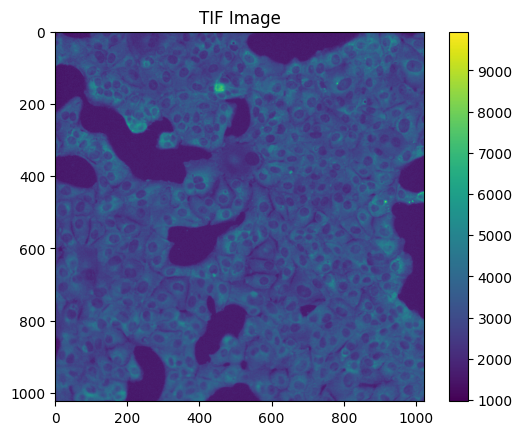

In [6]:
# get a .tif file and plot it
image_path = tif_file_paths["train"][5]
print(image_path)
# Read the .tif image using imageio
image = imageio.v2.imread(image_path)

# Display the image using matplotlib
plt.imshow(image)  # , cmap='gray' Assuming a grayscale image, adjust cmap if it's a color image
plt.title('TIF Image')
plt.colorbar()
plt.show()

### Content of One Image File Set
One image file set contains six .tif files. Three of those are the images (the name contains "image") and the other three files contain labels (the name contains "labels").  
In the following code you will find plots to all of the files mentioned with their corresponding name.

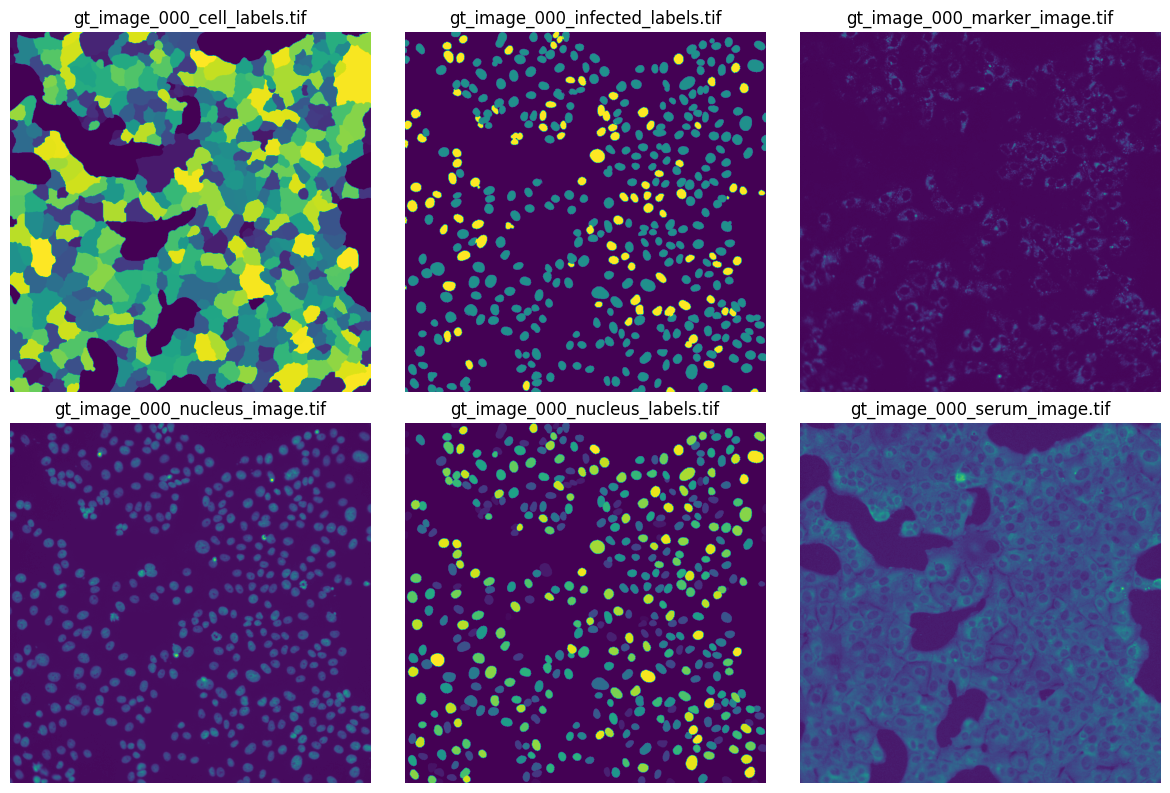

In [7]:
# Create a subplot with 2 rows and 3 columns
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
image_paths = tif_file_paths["train"][0:6]

# Loop through the image paths and display each image in a subplot
for i, ax in enumerate(axes.flatten()):
    # Read the .tif image using imageio
    image = imageio.v2.imread(image_paths[i])

    # Display the image in the current subplot
    ax.imshow(image)  # , cmap='gray' Assuming grayscale images, adjust cmap for color images
    ax.set_title(os.path.basename(image_paths[i]))
    ax.axis('off')  # Turn off axis labels for cleaner display

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

### Further Explanation
You should see several images that are part of one image data set. The following files contain the images:

- gt_image_000_marker.tif the antibody staining that stains the cytosol with an intensity that scales with the antbody binding.
- gt_image_000_nuceleus_image.tif contains the nucleus staining.
- gt_image_000_serum_image.tif contains a viral marker that can be used to check whether a cell is infected or not.  

The other files contain the ground-truth data:

- gt_image_000_cells.tif contains the cell instance segmentation.
- gt_image_000_nucleus_labels.tif contains a semantic nucleus segmentation.
- gt_image_000_infected_labels.tif contains a semantic nucleus segmentation, where the infected cells are highlighted.  

In addition, each image data set has a labels.json that contains additional information about the cell segmentation:  
In the following cell you will find a a glimps of the labels.json

In [8]:
# lables.json
# print(json_files)
with open(json_file_paths["train"][0], 'r') as f:
    json_file = json.load(f)
print(json_file["cells"][:5])

[{'cell_id': 0, 'infected_label': 0, 'bbox': None}, {'cell_id': 2, 'infected_label': 1, 'bbox': [46, 0, 70, 11]}, {'cell_id': 3, 'infected_label': 2, 'bbox': [718, 0, 775, 30]}, {'cell_id': 6, 'infected_label': 2, 'bbox': [524, 0, 556, 20]}, {'cell_id': 7, 'infected_label': 1, 'bbox': [992, 606, 1024, 670]}]


### Description to labels.json
The labels.json file contains information about the cells in the corresponding image located in the same directory.  
Each cell is annotated with `cell_id`, `infected_label` and `bbox` (bounding box). The structure of the bounding boxes are: **(min_row, min_col, max_row, max_col)**  
**Note:** The cell with the ID `0` does not represent a real cell and thus, it does not have a bounding box. This holds true for each image data set.    
In the following cell you will find a glimpse of the cell_labels.tif where you can see that all pixels have a value either belonging to the background (no cells) or the pixels have a unique value corresponding to the `cell_id`.  

In [9]:
print(tif_file_paths["train"][0], imageio.v2.imread(tif_file_paths["train"][0]))

data/train/gt_image_000/gt_image_000_cell_labels.tif [[ 16  16  16 ... 385 385 385]
 [ 16  16  16 ... 385 385 385]
 [ 16  16  16 ... 385 385 385]
 ...
 [  9   9   9 ...  19  19  19]
 [  9   9   9 ...  19  19  19]
 [  9   9   9 ...  19  19  19]]


## Combine Information
The next step is to combine the information from .tif and .json to visualize the cells with their labels in order to compare them. 

In [10]:
# prepare the labels and bounding boxes

rand_cell_ids = random.sample(population=range(1, len(json_file["cells"]) + 1), k=16)   
bboxes = []
labels = []
for i in rand_cell_ids:
    labels.append(json_file["cells"][i]["infected_label"])
    bboxes.append(json_file["cells"][i]["bbox"])
print(bboxes, labels)

[[689, 473, 779, 595], [83, 918, 132, 954], [446, 100, 508, 196], [0, 473, 72, 557], [156, 797, 206, 844], [39, 917, 175, 1024], [11, 11, 99, 79], [58, 902, 96, 945], [579, 616, 649, 672], [391, 156, 464, 258], [114, 474, 159, 521], [998, 158, 1024, 197], [453, 41, 515, 106], [162, 128, 210, 163], [640, 378, 688, 430], [291, 388, 326, 430]] [1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 2, 2, 1, 1]


### Plot the Image
In the following code we combine the three images files into one RGB image by putting the images into the three RGB images channels and stacking them into one RGB image.  


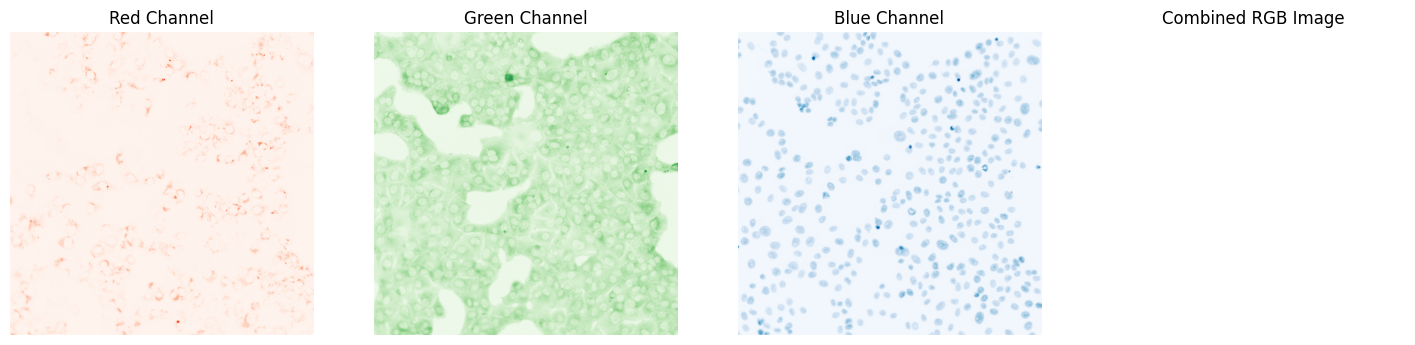

In [11]:
# load images and stack them to get one combined image
cell_segments_path, red_channel_path, blue_channel_path, green_channel_path  = [path for path in tif_file_paths["train"][0:6] if "cell_labels" in path or"marker" in path or "nucleus_image" in path or "serum_image" in path]

red_channel = imageio.v2.imread(red_channel_path)
green_channel = imageio.v2.imread(green_channel_path)
blue_channel = imageio.v2.imread(blue_channel_path)

# Stack the channels to form the RGB image
rgb_image = np.stack([red_channel, green_channel, blue_channel], axis=-1)

# Create subplots
fig, axs = plt.subplots(1, 4, figsize=(18, 12))

# Plot the individual channels
axs[0].imshow(red_channel, cmap='Reds')
axs[0].set_title('Red Channel')

axs[1].imshow(green_channel, cmap='Greens')
axs[1].set_title('Green Channel')

axs[2].imshow(blue_channel, cmap='Blues')
axs[2].set_title('Blue Channel')

# Plot the combined RGB image
axs[3].imshow(rgb_image)
axs[3].set_title('Combined RGB Image')

# Hide the axes labels and ticks for better visualization
for ax in axs:
    ax.axis('off')

plt.show()

## Problem with Representing the RGB Image
As you can see above, there is a problem with the representation of the RGB image. This is due to the values running out of the interpretable range of RGB images:  
To solve this problem we need to normalize the values. Best practice is to combine the normalization step when reading the image files:

In [12]:
# # Load images with imageio and normalize pixel values to uint8 range

def read_and_normalize(image_path, percentile_low=1, percentile_high=99):
    image = imageio.v2.imread(image_path)

    # Calculate the percentiles
    low_value, high_value = np.percentile(image, (percentile_low, percentile_high))

    # Clip pixel values to the percentiles
    clipped_image = np.clip(image, low_value, high_value)

    # Normalize pixel values to the range [0, 255]
    normalized_image = ((clipped_image - low_value) / (high_value - low_value) * 255).astype(np.uint8)

    return normalized_image

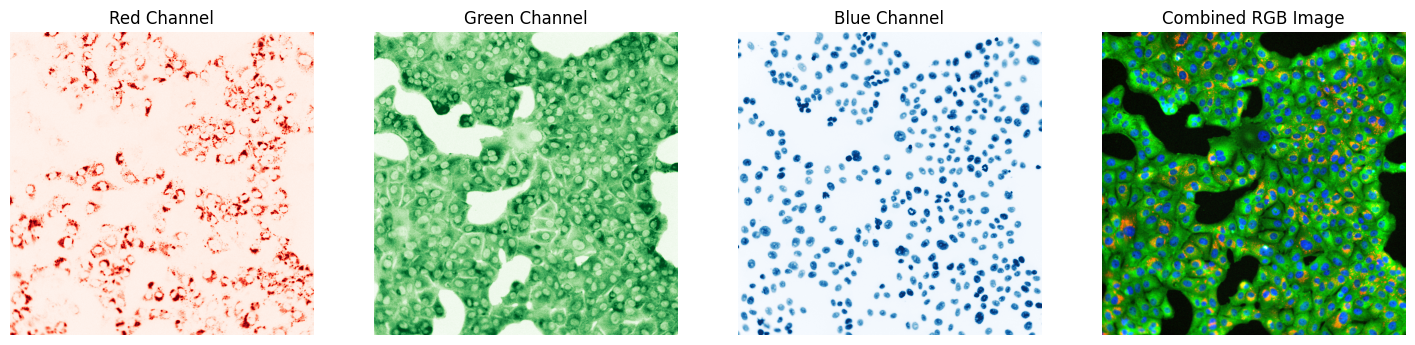

In [13]:
# load images and stack them to get one combined image
cell_segments_path, red_channel_path, blue_channel_path, green_channel_path  = [path for path in tif_file_paths["train"][0:6] if "cell_labels" in path or"marker" in path or "nucleus_image" in path or "serum_image" in path]

red_channel = read_and_normalize(red_channel_path)
green_channel = read_and_normalize(green_channel_path)
blue_channel = read_and_normalize(blue_channel_path)

# Stack the channels to form the RGB image
rgb_image = np.stack([red_channel, green_channel, blue_channel], axis=-1)

# Create subplots
fig, axs = plt.subplots(1, 4, figsize=(18, 12))

# Plot the individual channels
axs[0].imshow(red_channel, cmap='Reds')
axs[0].set_title('Red Channel')

axs[1].imshow(green_channel, cmap='Greens')
axs[1].set_title('Green Channel')

axs[2].imshow(blue_channel, cmap='Blues')
axs[2].set_title('Blue Channel')

# Plot the combined RGB image
axs[3].imshow(rgb_image)
axs[3].set_title('Combined RGB Image')

# Hide the axes labels and ticks for better visualization
for ax in axs:
    ax.axis('off')

plt.show()

## Add the Cell Segmentation
In the next code we will have a look at the cell_labels.tif file. By just the outlines of the cell_labels we can contour the RGB image with the outlines of the cells. 

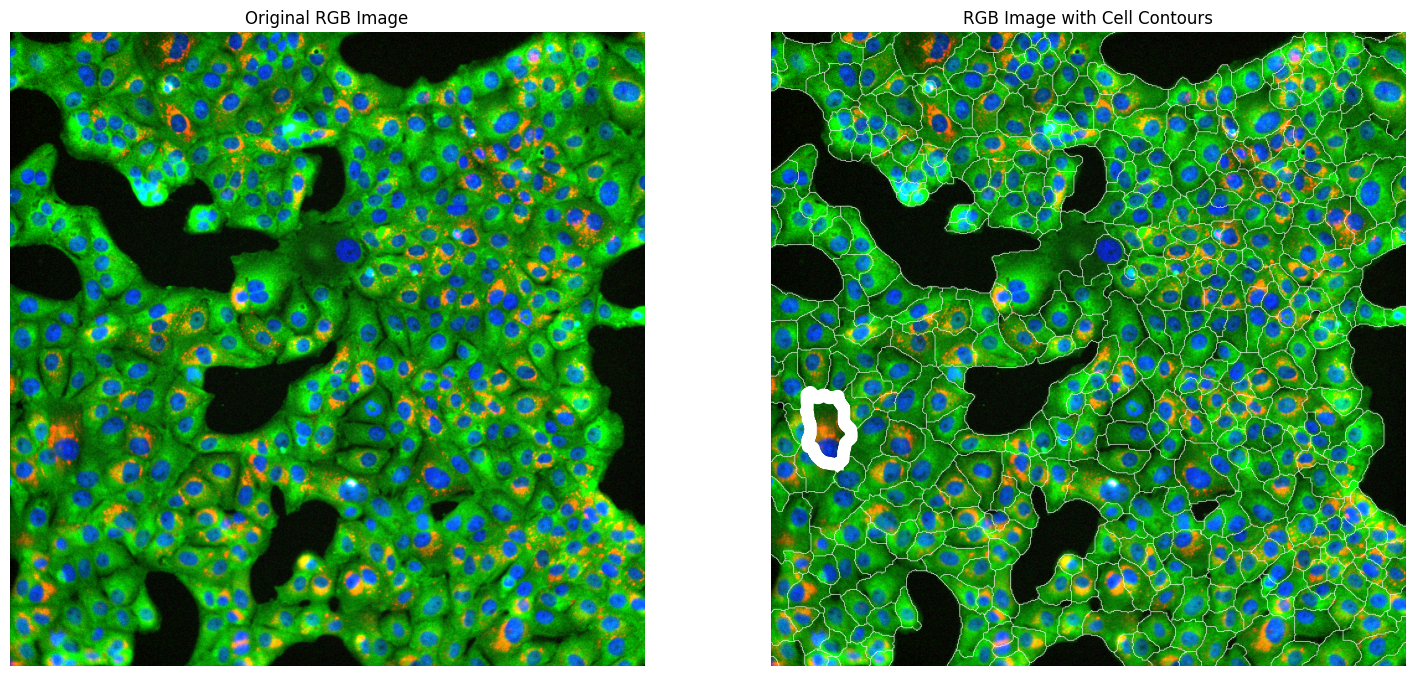

In [14]:
# Load images and stack them to get one combined image
cell_segments_path, red_channel_path, blue_channel_path, green_channel_path = [
    path for path in tif_file_paths["train"][0:6] if "cell_labels" in path or "marker" in path or "nucleus_image" in path or "serum_image" in path
]

red_channel = read_and_normalize(red_channel_path)
green_channel = read_and_normalize(green_channel_path)
blue_channel = read_and_normalize(blue_channel_path)

# Stack the channels to form the RGB image
rgb_image = np.stack([red_channel, green_channel, blue_channel], axis=-1)

# Load cell segments from a .tif file
cell_segments = imageio.v2.imread(cell_segments_path)

# Get the unique labels in the cell segments
unique_labels = np.unique(cell_segments)

# Overlay cell contours on the RGB image
rgb_image_with_contours = np.copy(rgb_image)

for label in unique_labels:
    # Create a binary mask for the current label
    label_mask = (cell_segments == label)

    # Get the contours of the labeled cells
    labeled_cells_contours = measure.find_contours(label_mask, 0.5)

    # Overlay contours on the RGB image
    for contour in labeled_cells_contours:
        # Convert the contour to integer coordinates
        contour_int = np.round(contour).astype(int)

        # Draw the contour on the RGB image with white color and increased thickness
        rgb_image_with_contours[contour_int[:, 0], contour_int[:, 1], :] = [255, 255, 255]  # White color for contours

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(18, 12))

# Plot the original RGB image
axs[0].imshow(rgb_image)
axs[0].set_title('Original RGB Image')
axs[0].axis('off')

# Plot the RGB image with cell contours using the plot function
for contour in labeled_cells_contours:
    axs[1].plot(contour[:, 1], contour[:, 0], color='white', linewidth=9)  # White color and increased thickness

axs[1].set_title('RGB Image with Cell Contours')
axs[1].imshow(rgb_image_with_contours)
axs[1].axis('off')

plt.show()

## Combine the RGB Image with the Infection Labels
The next code shows how to overlay the RGB iamge with a label mask. The labels show which cells/nuclei are infected.

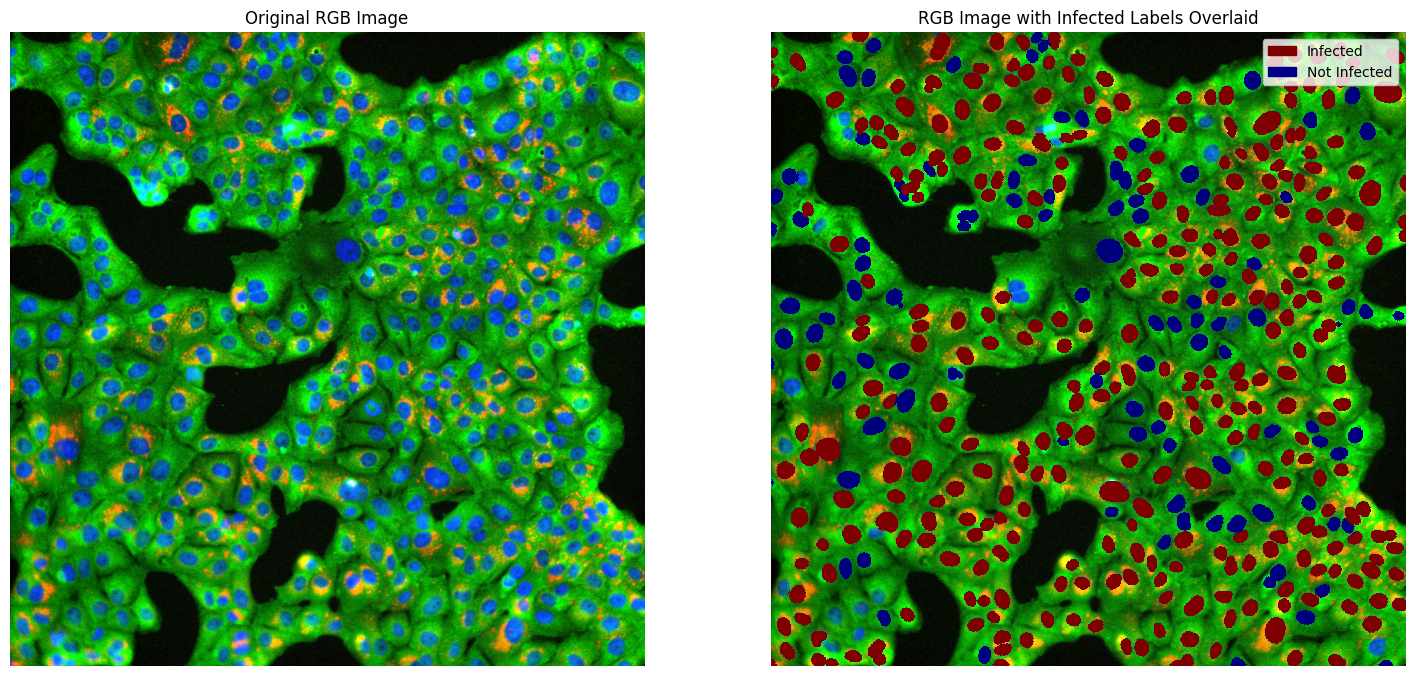

In [15]:
# Load images and stack them to get one combined RGB image
cell_labels_path, infected_labels_path, red_channel_path, blue_channel_path, nucleus_labels_path, green_channel_path = [
    path for path in tif_file_paths["train"][0:6]
]

# Load and normalize channels
red_channel = read_and_normalize(red_channel_path)
green_channel = read_and_normalize(green_channel_path)
blue_channel = read_and_normalize(blue_channel_path)

# Stack the channels to form the RGB image
rgb_image = np.stack([red_channel, green_channel, blue_channel], axis=-1)

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(18, 12))

# Plot the original RGB image
axs[0].imshow(rgb_image)
axs[0].set_title('Original RGB Image')
axs[0].axis('off')

# Plot RGB image with infected labels overlaid using colormap
# Load infected labels from .tif file
infected_labels = imageio.v2.imread(infected_labels_path)
masked = np.ma.masked_where(infected_labels == 0, infected_labels)

axs[1].imshow(rgb_image)
# 'jet_r' for the reversed colormap 
im = axs[1].imshow(masked, cmap='jet_r', interpolation='none') 
axs[1].set_title('RGB Image with Infected Labels Overlaid')
axs[1].axis('off')

# Obtain the color values from the colormap
cmap_colors = plt.colormaps.get_cmap('jet_r')

# Create a legend with color patches using the colormap colors
legend_elements = [Patch(color=cmap_colors(0), label='Infected'),
                   Patch(color=cmap_colors(0.99), label='Not Infected')]


# Add legend to the plot
axs[1].legend(handles=legend_elements, loc='upper right')

plt.show()

## Combine the Image with Bounding Boxes
The following code show how to plot bounding boxes of cells using the information from the labels.json file.   
The function `add_bounding_boxes` is used to plot the rectangles to the RGB image.

In [16]:
def add_bounding_boxes(image, bounding_boxes, color='r', linewidth=2):
    image_with_boxes = np.copy(image)
    for bbox in bounding_boxes:
        min_row, min_col, max_row, max_col = bbox
        rect = Rectangle((min_col, min_row), max_col - min_col, max_row - min_row,
                         linewidth=linewidth, edgecolor=color, facecolor='none')
        plt.gca().add_patch(rect)
    return image_with_boxes

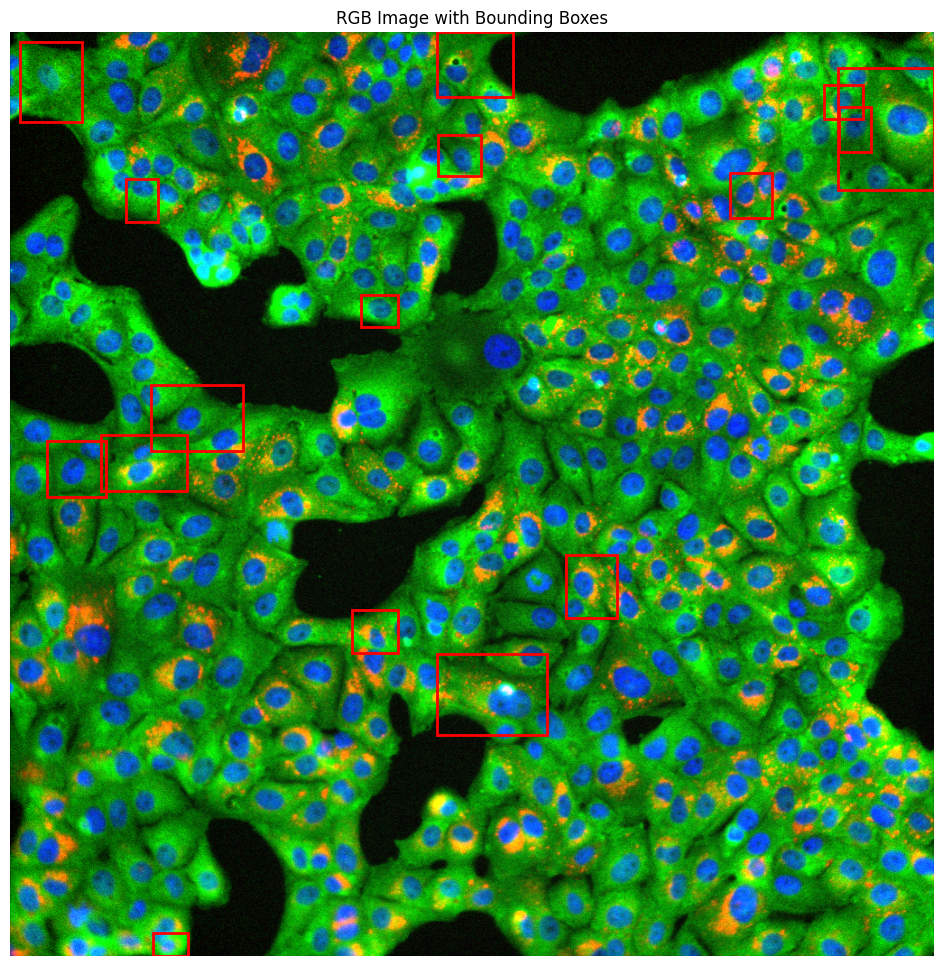

In [17]:
# Load images and stack them to get one combined image
#red_channel_path, blue_channel_path, green_channel_path = [path for path in tif_file_paths["train"][0:3] if "marker" in path or "nucleus_image" in path or "serum_image" in path]

red_channel = read_and_normalize(red_channel_path)
green_channel = read_and_normalize(green_channel_path)
blue_channel = read_and_normalize(blue_channel_path)

# Stack the channels to form the RGB image
rgb_image = np.stack([red_channel, green_channel, blue_channel], axis=-1)

# Create a figure with a specific size
plt.figure(figsize=(16, 12))

# Add bounding boxes to the RGB image
rgb_image_with_boxes = add_bounding_boxes(rgb_image, bboxes)

# Plot the RGB image with bounding boxes
plt.imshow(rgb_image_with_boxes)
plt.title('RGB Image with Bounding Boxes')

# Hide the axes labels and ticks for better visualization
plt.axis('off')

plt.show()

## Have a closer Look at the Cells
The following code shows how to zoom into the area inside the bounding boxes to have a better understanding.  
This also allows us to add labels to the subplots so we can see which label corresponds to the status of the cell **(possible stati: not known, not infected, infected, could not be determined)**

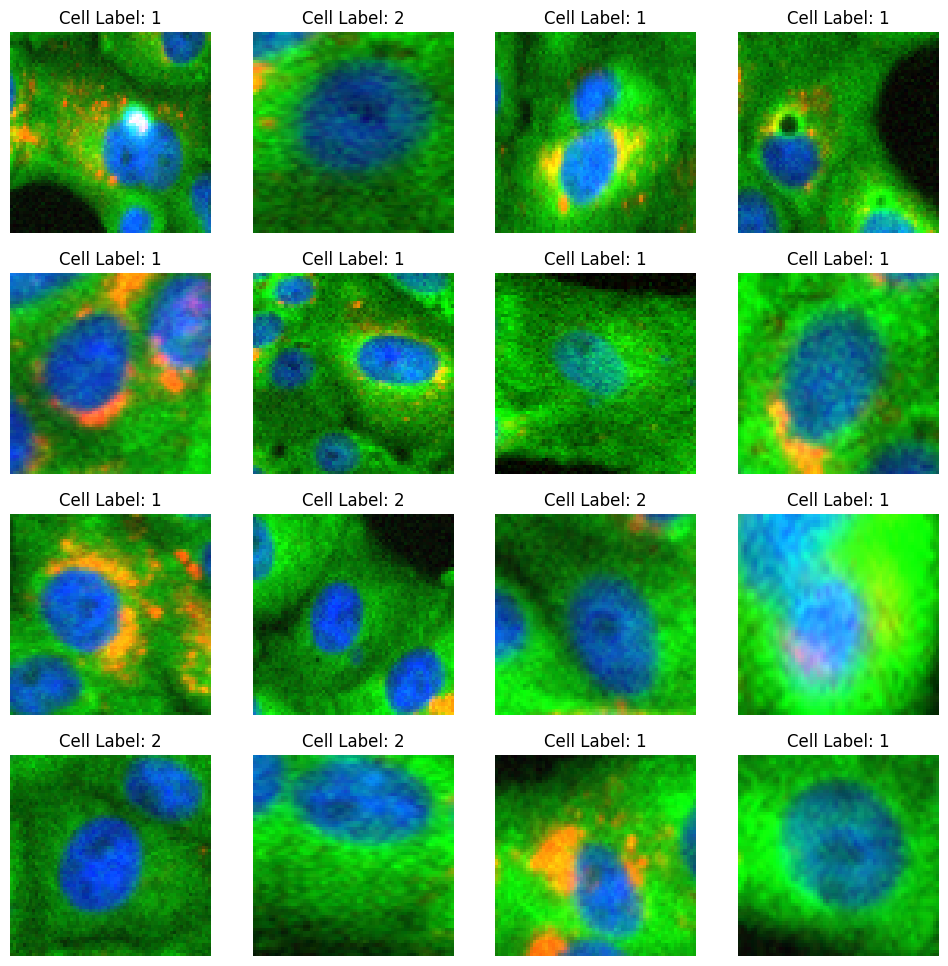

In [18]:
# cut bounding boxes of cells and plot them
# Create subplots
fig, axs = plt.subplots(4, 4, figsize=(12, 12))

# Desired size for all cells
desired_size = (64, 64)

for i, (min_row, min_col, max_row, max_col) in enumerate(bboxes):
    # Extract the cell from the RGB image
    cell = rgb_image[min_row:max_row, min_col:max_col, :]
    
    # Resize the cell to the desired size using scipy
    resized_cell = zoom(cell, (desired_size[0] / cell.shape[0], desired_size[1] / cell.shape[1], 1), order=3)

    # Plot the cell
    axs[i // 4, i % 4].imshow(resized_cell)
    axs[i // 4, i % 4].set_title(f'Cell Label: {labels[i]}')

    # Hide the axes labels and ticks for better visualization
    axs[i // 4, i % 4].axis('off')

plt.show()
